Dataset preview:
      XMEAS1       XMEAS2       XMEAS3    XMEAS4     XMEAS5     XMEAS6  \
0  0.271033  3649.739415  4451.320791  9.223142  32.392900  47.559754   
1  0.270826  3653.341885  4488.640140  9.211980  32.501953  47.374855   
2  0.270474  3688.113265  4432.832766  9.235690  32.402838  47.817088   
3  0.272127  3651.680041  4459.268940  9.192009  31.876790  47.869249   
4  0.270939  3636.329271  4460.409756  9.277992  32.424754  47.509322   

        XMEAS7     XMEAS8      XMEAS9   XMEAS10  ...    XMEAS22       XMV1  \
0  2798.975799  64.995825  122.898796  0.197826  ...  92.262531  62.806984   
1  2800.296214  65.091251  122.877519  0.196092  ...  92.492697  62.819324   
2  2802.647777  64.812363  122.916165  0.204023  ...  92.368550  62.836835   
3  2803.693084  64.205417  122.892493  0.220561  ...  92.310705  62.848190   
4  2804.787223  64.598623  122.890514  0.236146  ...  92.215839  62.848341   

        XMV2       XMV3       XMV4       XMV6       XMV7       XMV8  \
0  

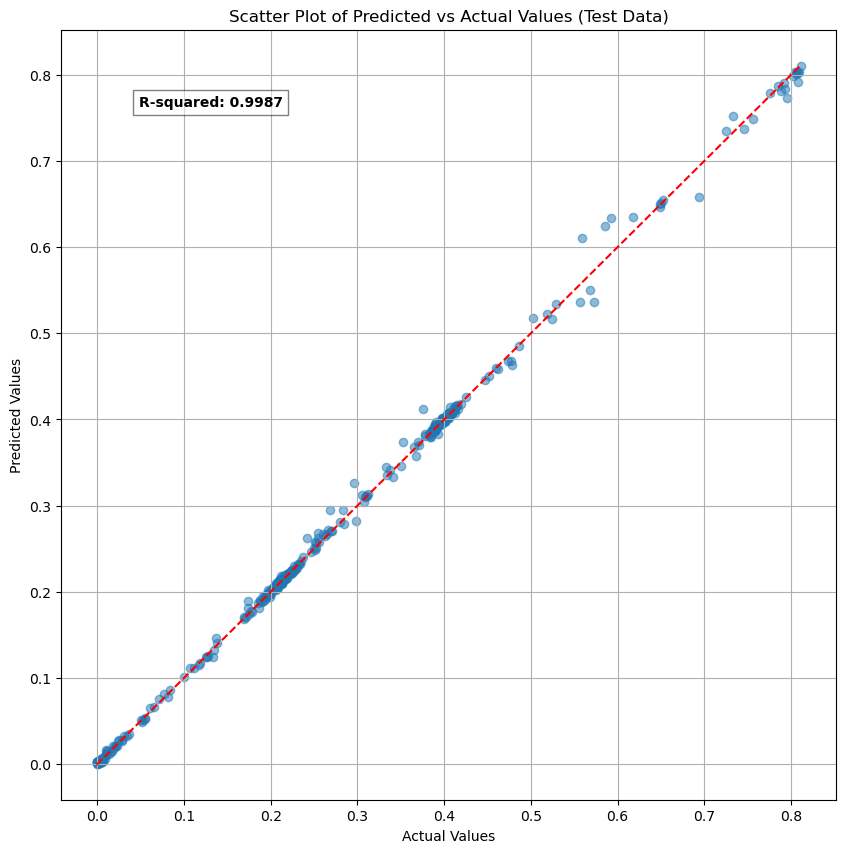

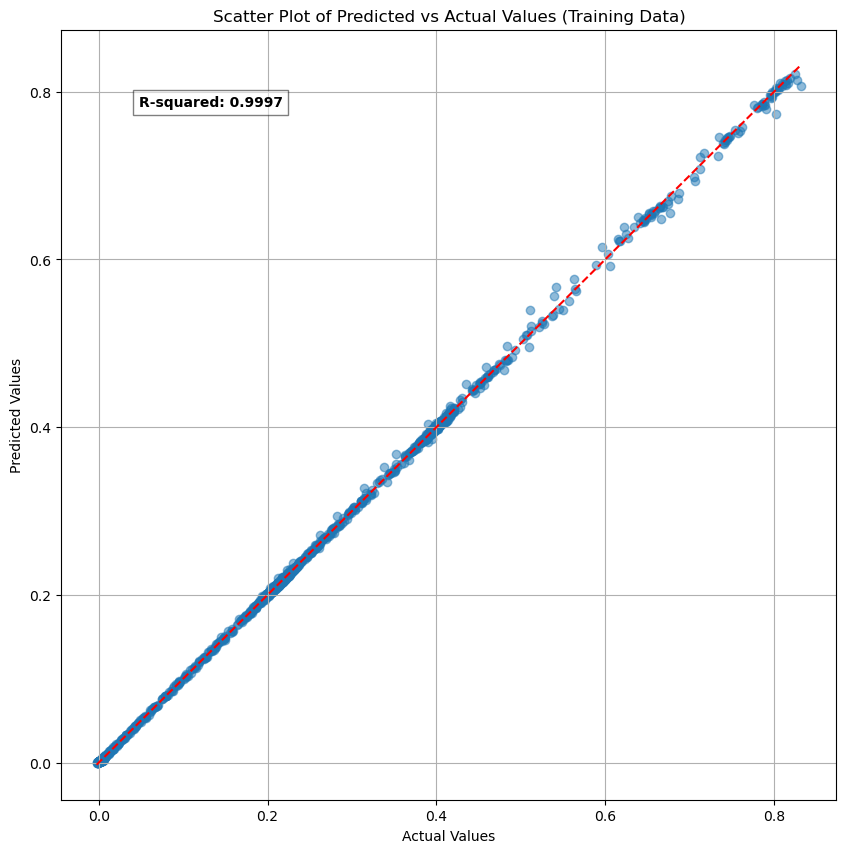

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ---------------------- Data Loading & Preprocessing ---------------------- #

# Load dataset
data = pd.read_csv('../data/clean_RawData.csv')

# Drop unnecessary columns if present
data.drop(columns=[col for col in ['INDEX', 'Unnamed: 0'] if col in data.columns], inplace=True)

# Handle missing values
data.fillna(data.mean(), inplace=True)

# Preview the dataset
print("Dataset preview:\n", data.head())

# Separate features and target
X = data.drop(columns='XMEAS10')
y = data['XMEAS10']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ---------------------- Model Training: Random Forest ---------------------- #

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Train the model
grid_search.fit(X_train, y_train)

# Best model from grid search
best_rf = grid_search.best_estimator_

# ---------------------- Evaluation ---------------------- #

# Predictions
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Calculate RMSE and R²
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print metrics
print(f"\nTraining RMSE: {rmse_train:.4f}")
print(f"Testing RMSE: {rmse_test:.4f}")
print(f"Training R²: {r2_train:.4f}")
print(f"Testing R²: {r2_test:.4f}")

# ---------------------- Visualization ---------------------- #

# Function to create scatter plot
def plot_scatter(actual, predicted, title, filename, r2_value):
    plt.figure(figsize=(10, 10))
    plt.scatter(actual, predicted, alpha=0.5)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 
             color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.text(0.1, 0.9, f'R-squared: {r2_value:.4f}', transform=plt.gca().transAxes,
             fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.5))
    plt.grid(True)
    plt.savefig(filename, format='png')
    plt.show()

# Plot for test data
plot_scatter(y_test, y_test_pred, 
             'Scatter Plot of Predicted vs Actual Values (Test Data)', 
             '../plots/RF_test_scatter_plot.png', r2_test)

# Plot for training data
plot_scatter(y_train, y_train_pred, 
             'Scatter Plot of Predicted vs Actual Values (Training Data)', 
             '../plots/RF_training_scatter_plot.png', r2_train)
